In [24]:
import numpy as np 
from scipy.integrate import quad 
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pathos.multiprocessing import ProcessingPool
from functools import partial
from matplotlib.colors import LogNorm

In [67]:
def phi_0(k: np.array) -> float:
    k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
    # hydrogen_100 = 1 / (np.sqrt(np.pi) * c.a0.value**(3/2)) * np.exp(-r_size / c.a0.value)
    # tot_phi_0 = 1 / (2 * np.pi)**(3/2)
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.cos(w * t + phase)
    return val



def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             #sin4cos2, sin4sin2, sin2cos, sin2sin
            ) -> float:
    """
    sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
    """
    
    i = complex(0, 1)
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
    test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
    test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
    test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts)[0]
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, complex_func=True)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts)[0]
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, complex_func=True)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    
    
def plot_log(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals, norm=LogNorm())

    ax.invert_yaxis()

    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
    ax.tick_params(direction="inout", right=True, top=True)

    cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    cbar.ax.set_ylabel('Log scale')

    plt.show()
    
    return

def plot(xs, ys, vals) -> None:
    fig, ax = plt.subplots()
    im = ax.scatter(xs, ys, c=vals)

    ax.tick_params(direction="inout", right=True, top=True)
    ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

    fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
    return

### Standard values

In [26]:
I = 5e13
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_400 = w_800 * 800 / 400
w_s = w_400

A_0_s = F_0 / w_400

E_0_s = -13.6 / conversion_ev_au

N_s = 7
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 0.5

In [27]:
k_test = np.array([1, 1, 0])

val = M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:446: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/Users/mikkelsewerin/Library/Caches/pypoetry/virtualenvs/test-Mhj20Io5-py3.12/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:449: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the 

In [28]:
# complex_func=True for scipy
val.real, val.imag, val

(0.031088744052989194,
 -3.5857792381325206e-05,
 (0.031088744052989194-3.5857792381325206e-05j))

In [29]:
dp_dk(val)

0.0009665112925735454

In [12]:
# complex_func=False for scipy
val.real, val.imag, val

(0.0, -6.152672084090335e-07, -6.152672084090335e-07j)

In [13]:
dp_dk(val)

3.7855373774344507e-13

In [7]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]

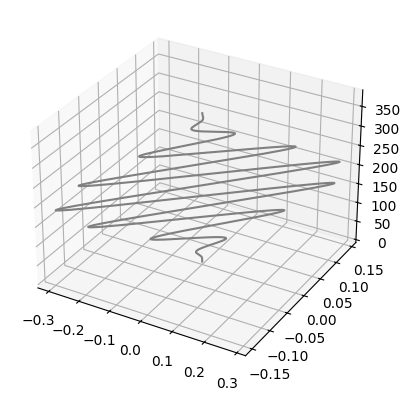

In [8]:
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [35]:
def compute_values(kx, kys, T_s, w_s, A_0_s, E_0_s, phase_s):
    return [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]

length = 101

start_val_x = -10
end_val_x = 10

start_val_y = -10
end_val_y = 10

kxs = np.linspace(start_val_x, end_val_x, length)
kys = np.linspace(start_val_y, end_val_y, length)

# Create a pool of worker processes using pathos
pool = ProcessingPool()  

# Create a partial function with fixed arguments except for kx
partial_compute_values = partial(
    compute_values, kys=kys, T_s=T_s, w_s=w_s, A_0_s=A_0_s, E_0_s=E_0_s, phase_s=phase_s)

# Map the partial function to kxs
results = pool.map(partial_compute_values, kxs)

kx_plot = np.repeat(kxs, length)
ky_plot = np.tile(kys, length)
values_plot = np.concatenate(results)

print("Done")


Done


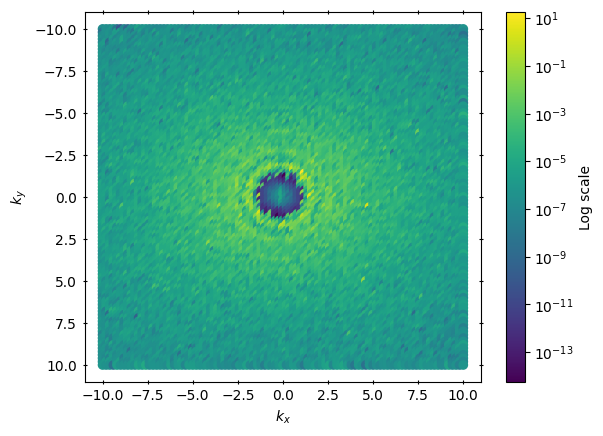

In [36]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, norm=LogNorm())

ax.invert_yaxis()

ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
ax.tick_params(direction="inout", right=True, top=True)

cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
cbar.ax.set_ylabel('Log scale')

plt.show()

In [30]:
A_0_s

0.32915874037472703

### Old method

In [ ]:
values_plot

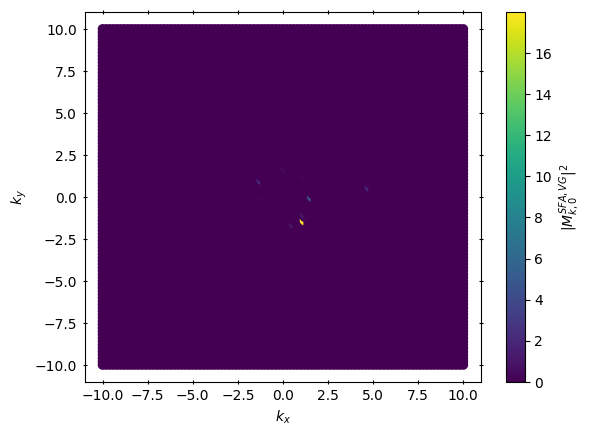

In [37]:
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot)

ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')

In [41]:
import pandas as pd

In [43]:
kx_plot

array([-10., -10., -10., ...,  10.,  10.,  10.])

In [49]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot

In [62]:
df.loc[df["dpdk"] < 1]

,kx,ky,dpdk
0,-10.0,-10.0,1.668116e-07
1,-10.0,-9.8,4.265351e-09
2,-10.0,-9.6,1.507731e-07
3,-10.0,-9.4,3.771493e-07
4,-10.0,-9.2,9.389547e-08
...,...,...,...
10196,10.0,9.2,7.770704e-07
10197,10.0,9.4,1.107277e-07
10198,10.0,9.6,3.464752e-07
10199,10.0,9.8,7.019669e-08


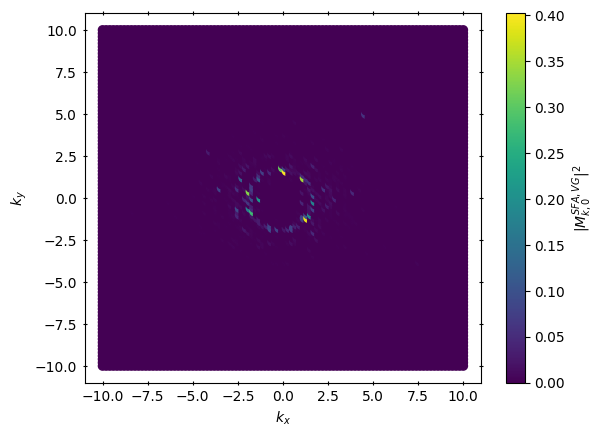

In [72]:
max_val = 1
plot(df.loc[df["dpdk"] < max_val, "kx"], 
     df.loc[df["dpdk"] < max_val, "ky"], df.loc[df["dpdk"] < max_val, "dpdk"])

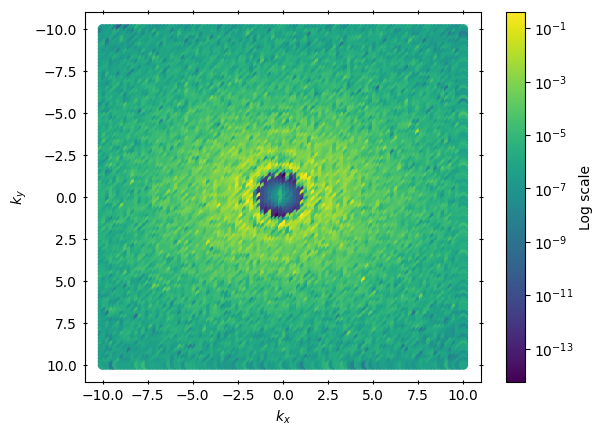

In [66]:
plot_log(df.loc[df["dpdk"] < 1, "kx"], df.loc[df["dpdk"] < 1, "ky"], df.loc[df["dpdk"] < 1, "dpdk"])

length = 5
start_val = -4
end_val = 4
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)



kx_plot = []
ky_plot = []
values_plot = []
for i, kx in enumerate(kxs):
    values = [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]
    print(i)
    kx_plot.extend(kx * np.ones(length))
    ky_plot.extend(kys)
    values_plot.extend(values)
        